# Урок 3. Классификация. Логистическая регрессия.

1. Измените функцию predict(w, X) так, чтобы можно было подать порог для классификации.
2. Подберите аргументы функции optimize для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.
4. Постройте кривую оббучения (значение оценки потерь от итерации) для примеров из тренировочной и тестовой выборки
5. Оцените результаты и сделайте выводы.
6. Попробуйте ответить на вопросы: Могла ли модель переобучиться? На каком шаге это произошло? Почему?

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

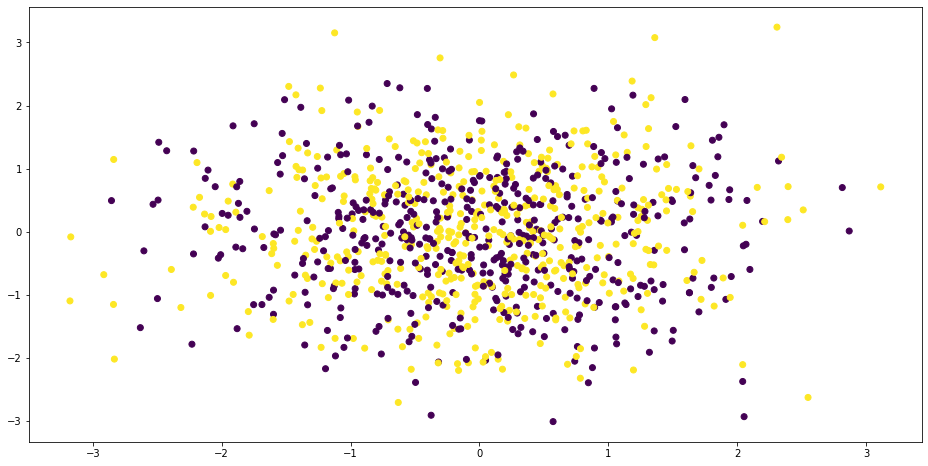

In [2]:
X, Y = datasets.make_classification(n_samples=1000, n_features=5, n_informative=3,
                                       n_redundant=0, n_classes=2, random_state=42)

plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [3]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(X.shape[0])
X_shuffled, y_shuffled = X[shuffle_index], Y[shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(X) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]    

In [4]:
X_train_T, X_test_T = X_train.transpose(), X_test.transpose()

y_train_T, y_test_T = y_train.reshape(1, y_train.shape[0]), y_test.reshape(1, y_test.shape[0])

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
def log_loss(w, X, y):
    m = X.shape[1]

    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

In [7]:
def optimize(w, X, y, n_iterations, eta):
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses

In [8]:
def predict(w, X, threshold=0.5):
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
    for i in range(A.shape[1]):
        if (A[:, i] > threshold): 
            y_predicted[:, i] = 1
        elif (A[:, i] <= threshold):
            y_predicted[:, i] = 0
    
    return y_predicted

In [9]:
def accuracy(y_pred, y_true):
    return 100.0 - np.mean(np.abs(y_pred - y_true) * 100.0)

In [10]:
def get_train_test_accuracy(w, X_test, X_train, y_test, y_train, threshold=0.5):

    y_predicted_test = predict(w, X_test, threshold)
    y_predicted_train = predict(w, X_train, threshold)

    train_accuracy = accuracy(y_predicted_train, y_train)
    test_accuracy = accuracy(y_predicted_test, y_test)
    
    return (train_accuracy, test_accuracy)

In [11]:
def plot_train_test(label, data_list):
    plt.figure(figsize=(16, 10))
    for data in data_list:
        plt.scatter(data[0], data[1], label = f'Train for {data[0]}')
        plt.scatter(data[0], data[2], label = f'Test for {data[0]}')

    plt.xlabel(label)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [12]:
def plot_loss(loss):
    plt.figure(figsize=(16, 10))
    plt.title('Log loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.plot(range(len(loss)), loss)

In [13]:
def plot_losses(data_list):
    plt.figure(figsize=(16, 10))
    for data in data_list:
        plt.plot(range(len(data[1])), data[1], label = f'Losses for {data[0]}')

    plt.xlabel('Iterations')
    plt.ylabel('Losses')
    plt.grid(True)
    plt.legend()
    plt.show()

In [14]:
w0 = np.zeros((X_train_T.shape[0], 1))

accuracy_list_iter = []
losses_list_iter = []

threshold = 0.5
eta = 0.05
for n_iterations in [100, 250, 500, 750, 1000, 2000]:
    w, losses = optimize(w0, X_train_T, y_train_T, n_iterations, eta)

    train_accuracy, test_accuracy = get_train_test_accuracy(w, X_test_T, X_train_T, y_test_T, y_train_T, threshold)

    accuracy_list_iter.append((n_iterations, train_accuracy, test_accuracy))
    losses_list_iter = losses

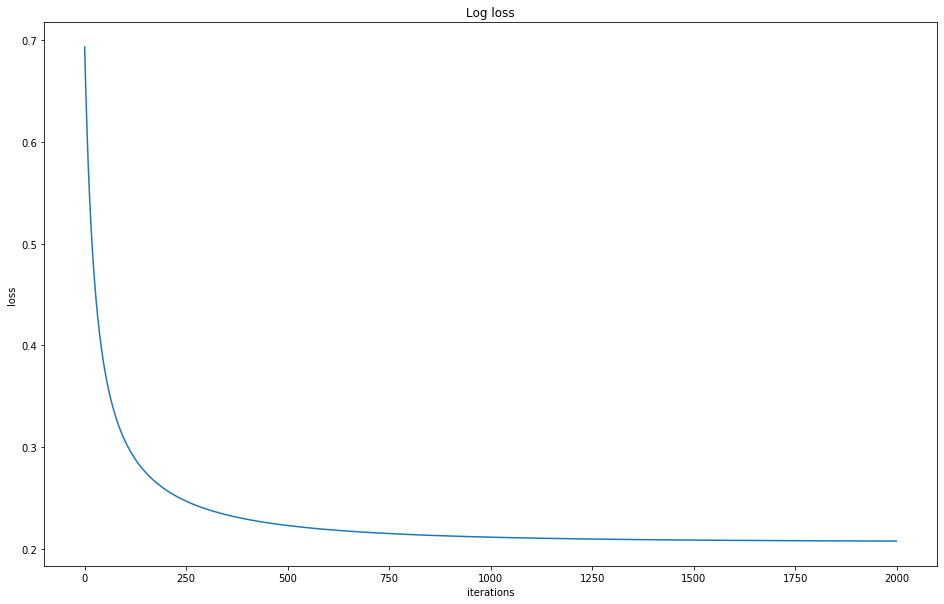

In [15]:
plot_loss(losses_list_iter)

**Вывод:** на 1500 итераций достигается минимум функции, т.е. это значение оптимально, выберем его для дальнейших расчетов.

In [16]:
accuracy_list_eta = []
losses_list_eta = []

threshold = 0.5
n_iterations = 1500
for eta in [0.001, 0.005, 0.05, 0.1, 0.5]:
    w, losses = optimize(w0, X_train_T, y_train_T, n_iterations, eta)

    train_accuracy, test_accuracy = get_train_test_accuracy(w, X_test_T, X_train_T, y_test_T, y_train_T, threshold)

    accuracy_list_eta.append((eta, train_accuracy, test_accuracy))
    losses_list_eta.append((eta, losses))

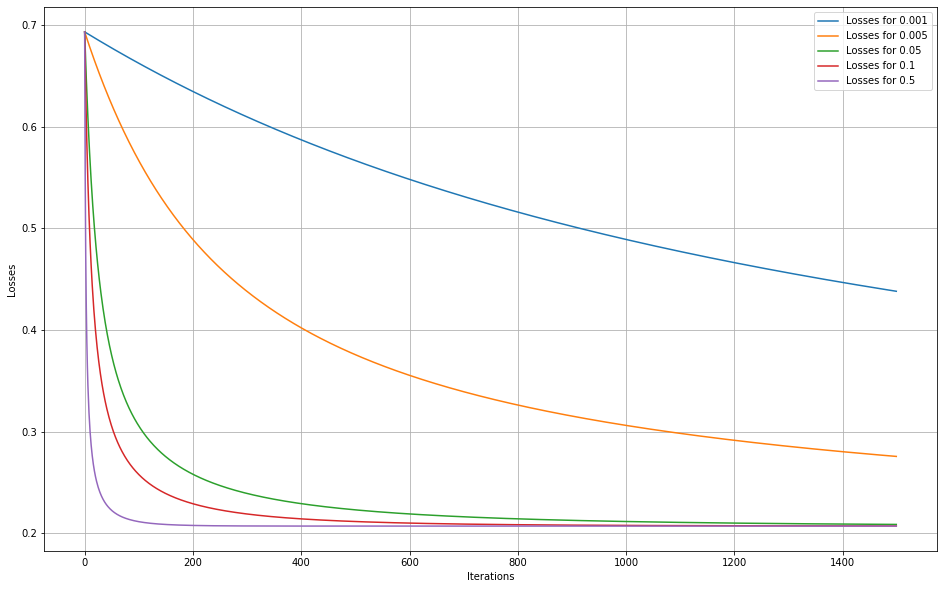

In [17]:
plot_losses(losses_list_eta)

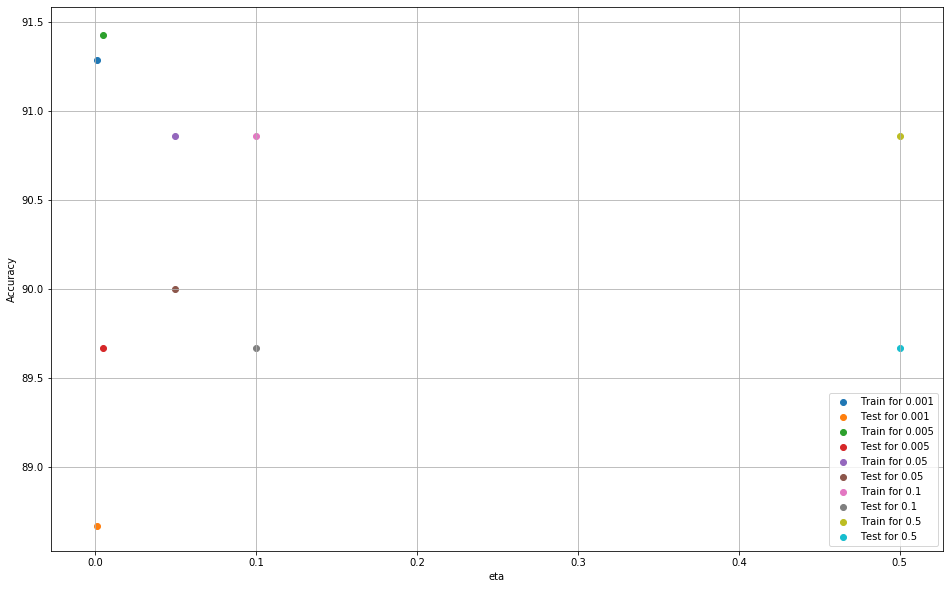

In [18]:
plot_train_test('eta', accuracy_list_eta)

**Вывод:** при eta=0.5 функция потерь приходит в минимум быстрее всего, но при этом точность, как видно из второго графика, не самая лучшая. Оптимальным значением будет eta=0.05.

In [19]:
threshold = 0.5
n_iterations = 1500
eta = 0.05

w, losses = optimize(w0, X_train_T, y_train_T, n_iterations, eta)

y_predicted_train = predict(w, X_train_T, threshold)
y_predicted_test = predict(w, X_test_T, threshold)

train_accuracy = accuracy(y_predicted_train, y_train_T)
test_accuracy = accuracy(y_predicted_test, y_test_T)

In [20]:
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Точность на обучающей выборке: 90.857
Точность на тестовой выборке: 90.000


In [21]:
def calc_err_matrix(y_pred, y_true):
    tp = fp = tn = fn = 0
    for i, y in enumerate(y_pred):
        if y == y_true[i]:
            if y == 0.0:
                tp += 1
            else:
                tn += 1
        elif y == 0.0:
            fp += 1
        else:
            fn += 1
            
    return tp, fp, tn, fn

**Тренировочная выборка**

In [22]:
tp, fp, tn, fn = calc_err_matrix(y_predicted_train[0], y_train)
tp, fp, tn, fn

(331, 39, 305, 25)

|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a_{2}(x) = +1$$__  |   331    |   39   |
| __$$a_{2}(x) = -1$$__ |   25    |   305   |

In [23]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f = 2 * precision * recall / (precision + recall)

print(f'Точность = {precision}, полнота = {recall}, F-мера = {f}')

Точность = 0.8945945945945946, полнота = 0.9297752808988764, F-мера = 0.9118457300275482


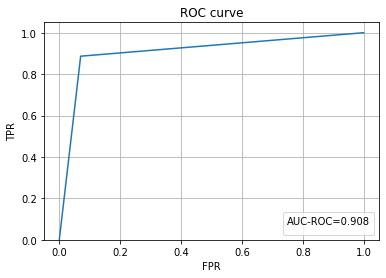

In [24]:
from sklearn.metrics import roc_curve
from numpy import trapz


fpr, tpr, thresholds = roc_curve(y_train, y_predicted_train[0])
AUC_ROC = trapz(tpr, x = fpr, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(fpr, tpr)
plt.show()

**Тестовая выборка**

In [25]:
tp, fp, tn, fn = calc_err_matrix(y_predicted_test[0], y_test)
tp, fp, tn, fn

(130, 18, 140, 12)

|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a_{2}(x) = +1$$__  |   130    |   18   |
| __$$a_{2}(x) = -1$$__ |   12    |   140   |

In [26]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f = 2 * precision * recall / (precision + recall)

print(f'Точность = {precision}, полнота = {recall}, F-мера = {f}')

Точность = 0.8783783783783784, полнота = 0.9154929577464789, F-мера = 0.896551724137931


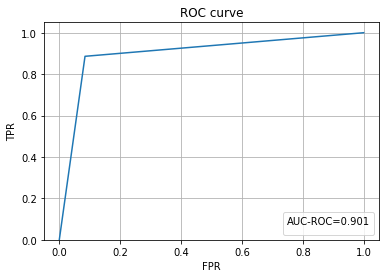

In [27]:
from sklearn.metrics import roc_curve
from numpy import trapz


fpr, tpr, thresholds = roc_curve(y_test, y_predicted_test[0])
AUC_ROC = trapz(tpr, x = fpr, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(fpr, tpr)
plt.show()

**Выводы:** для тестовых данных все оценки качества неммного снизились (~0,1). Полнота немного выше точности, но в целом все показатели примерно равны - нет сильных отклонений (0.87 - 0.915). Площадь под ROC кривой (для тестовых данных 0,901) практически совпадает с расчитанным значнием точности (0,900), можно сделать вывод, что данные сбалансированны, а модель достаточно точная.

Могла ли модель переобучиться? Может быть, если рассчитанные значения y будут близки к порогу threshold или плохо перемешаны до разделения на тестовую и трренировочную выборку. Других предположений не придумала